In [1]:
from symc.simulator import Simulator
from symc.plotting import corner_plot, CORNER, color_plot

In [2]:
from rich.pretty import pprint
import numpy as np
import matplotlib.pyplot as plt

In [3]:
sim = Simulator()
pprint(dict(sim.config))

{
│   'simulation': 'egg_box',
│   'input_dimension': 2,
│   'output_dimension': 1,
│   'bounds': [[10.0, 15.0]],
│   'normalised_input': False,
│   'norm_limits': [[-1, 1]],
│   'sim_config': None
}

#### Random uniform sampling

In [23]:
pprint(sim.sample(3))

array([[11.25785842, 12.58954501],
│      [14.52477404, 11.89408044],
│      [14.51834491, 12.87849405]])

In [5]:
x = sim.sample(5000)
y = sim(x)

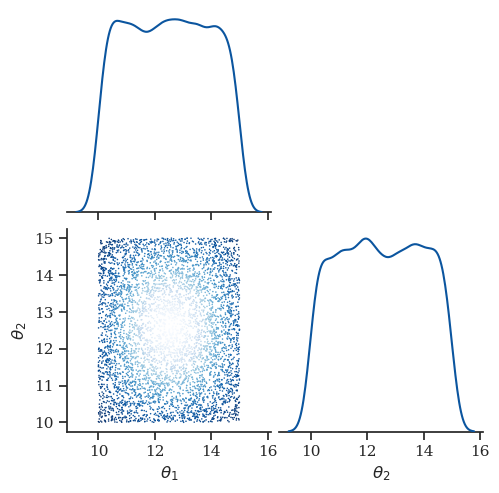

In [6]:
labels = [r'$\theta_1$', r'$\theta_2$']
g = color_plot(x, y, labels, cmap='Blues_r')
plt.show()

In [13]:
from symc.likelihoods import LIKELIHOODS

In [14]:
lh = LIKELIHOODS['single_gaussian']

In [24]:
pprint(lh(y,goal=100))

array([[1.10615505e-02],
│      [8.09489959e-18],
│      [1.59139815e-02],
│      ...,
│      [1.12920571e-09],
│      [1.42122609e-01],
│      [8.60108934e-01]])

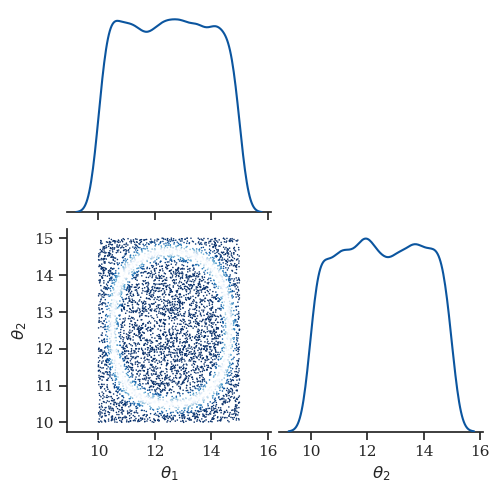

In [22]:
g = color_plot(x, lh(y,goal=100), labels, cmap='Blues_r')
plt.show()


In [29]:
import pandas as pd

In [30]:
df = pd.DataFrame(x)

In [32]:
type(df)

pandas.core.frame.DataFrame